# Exploratory Data Analysis

In this notebook, we will be importing the data and conducting EDA to evaluate our most pertinent features.

The following code will be processed in [A_eda.py](/py_scripts/A_eda.py). Always remember to update <u>A_eda.py</u> with any updates to this notebook.

***

# Importing libraries and Setting seeds

In [26]:
# Setting PYTHONHASHSEED
import os
print('Make sure the following says None: ', os.environ.get('PYTHONHASHSEED'))
os.environ['PYTHONHASHSEED'] = '0'
print('Make sure the following says 0: ', os.environ.get('PYTHONHASHSEED'))

Make sure the following says None:  0
Make sure the following says 0:  0


In [27]:
# Importing libraries
from pathlib import Path

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Setting seed
np.random.seed(42)

In [28]:
# SAVE_FIG: a function to save any visualizations in the "plots" folder
IMAGES_PATH = Path() / 'plots'

def save_fig(fig_name, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGES_PATH / f'{fig_name}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [29]:
# Importing data
adclicks = pd.read_csv('data/ad_click_dataset.csv')

***

## Overview of Data Structure

We will be examining the data and its underlying structure.

In [30]:
# Examining the top 10 rows
adclicks.head(10)

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
5,5942,User5942,NaN,Non-Binary,NaN,Bottom,Social Media,Evening,1
6,7808,User7808,26.0,Female,Desktop,Top,NaN,NaN,1
7,5065,User5065,40.0,Male,Mobile,Side,NaN,Evening,0
8,7993,User7993,NaN,Non-Binary,Mobile,Bottom,Social Media,NaN,1
9,4509,User4509,NaN,NaN,NaN,Bottom,Education,Afternoon,1


In [31]:
# More information on features
adclicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


In `adclicks.head(10)`, we saw quite a bit of missing information (NaN), and this is confirmed by running `adclicks.info()`.

A summary of `adclicks.info()`:

- There are 10,000 instances.
- `age`, `gender`, `device_type`, `ad_position`, `browsing_history`, and `time_of_day` have missing values.
- Most of the features are non-numeric, possibly categorical.

***

Let's examine what the possible values our non-numerical features have.

In [32]:
# Examine the possible values of non-numeric attributes
display(adclicks['gender'].value_counts())
display(adclicks['device_type'].value_counts())
display(adclicks['ad_position'].value_counts())
display(adclicks['browsing_history'].value_counts())
display(adclicks['time_of_day'].value_counts())

gender
Female        1834
Male          1810
Non-Binary    1663
Name: count, dtype: int64

device_type
Desktop    2754
Mobile     2649
Tablet     2597
Name: count, dtype: int64

ad_position
Bottom    2817
Top       2597
Side      2586
Name: count, dtype: int64

browsing_history
Entertainment    1175
Social Media     1054
Education        1029
Shopping          984
News              976
Name: count, dtype: int64

time_of_day
Morning      2126
Afternoon    2016
Evening      1958
Night        1900
Name: count, dtype: int64

With the different value counts of our non-numerical features, we can clearly see that they are intended to be categorical.

Each categorical feature represents the following:

- `gender`: the gender of the user (Male, Female, Non-Binary).
- `device_type`: the type of device of the user when viewing the ad (Mobile, Desktop, Tablet).
- `ad_position`: the position of the ad on the webpage (Top, Side, Bottom).
- `browsing_history`: the user's browsing activity prior to seeing the ad (Shopping, News, Entertainment, Education, Social Media).
- `time_of_day`: the time when the user viewed the ad (Morning, Afternoon, Evening, Night).

Our numerical features represent the following:

- `id`: unique ID for each user.
- `age`: the age of each user.
- `click`: the **target label** indicating whether the user clicked on the ad (Binary).

We will be using the categorical features to predict whether a user will click on an ad (`click`).

Since the `full_name` column as been anonymized and because I feel it is irrelevant, I will be removing it from our analysis. I will also be removing `id`.

In [33]:
# Dropping `full_name` and `id`
adclicks = adclicks.drop(columns=['full_name', 'id'], axis=1, inplace=False)

***

Let's quickly take a look at our numerical features.

In [34]:
# Look at numerical features and their characteristics
adclicks.describe()

,age,click
count,5234.000000,10000.000000
mean,40.197363,0.650000
std,13.126420,0.476993
min,18.000000,0.000000
25%,29.000000,0.000000
50%,39.500000,1.000000
75%,52.000000,1.000000
max,64.000000,1.000000


We can see that our most relevant numerical feature, `age`, ranges from 18 to 64, and the mean age is 40. The 25%, 50%, and 75% percentiles indicate that age is in a normal distribution but we will examine this further using a histogram later on in visualization.

***

# Splitting the Test Set

Considering that our target variable `click` is categorical, I am thinking that a **stratified-split** would be the best way to split our training and test data. We will also be generating multiple splits to reduce randomness and effectively use our data as much as possible.

In [35]:
# Checking the unique values of our target variable `click`
adclicks['click'].unique()

array([1, 0])

In [36]:
# Splitting our data
from sklearn.model_selection import StratifiedShuffleSplit

# Generating 10 different splits of 20/80 for test/train
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(adclicks, adclicks['click']):
    strat_train_set_n = adclicks.iloc[train_index]
    strat_test_set_n = adclicks.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

We can compare how well our stratified split occurred in comparison to a regular train-test split by comparing it with our actual data.

In [37]:
# We will be using the first split of our stratified splits
strat_train_set, strat_test_set = strat_splits[0]

***

# Visualizations

Let's visualize the distributions of our features. Since we will only be looking at the training set from now on, we will reassign the `adclicks` variable to just the training set.

In [38]:
# Make a copy of the training set incase we want to revert
adclicks = strat_train_set.copy()

## Barplots

Let's plot barplots for each of our categorical features to look at the counts of each category.

In [39]:
# PLOT_CATEGORICAL: a function to plot the categorical features in dataset
def plt_categorical(df):
    # Select the categorical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    num_categorical = len(categorical_features)

    # Creating a "square" plot
    sq_rows = math.floor(math.sqrt(num_categorical))
    sq_cols = num_categorical - sq_rows

    # Setting dimensions for figure
    fig, axes = plt.subplots(nrows=sq_rows, ncols=sq_cols, figsize=(5*sq_cols, 4*sq_rows))

    # Configure display for each subplot
    for ax, feature in zip(axes.flatten(), categorical_features):
        # Create a bar plot for each categorical variable
        sns.countplot(x=feature, data=df, ax=ax)
        ax.set_title(f'Count of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')

    # Make empty axes not visible
    for i in range(num_categorical, len(axes.flatten())):
        axes.flatten()[i].set_visible(False)
        
    # Adjust layout
    plt.tight_layout()

In [40]:
# PLT_SHOW: a function to name and save the image of the current plot
def plt_show(plt_name):
    save_fig(plt_name)
    plt.show()

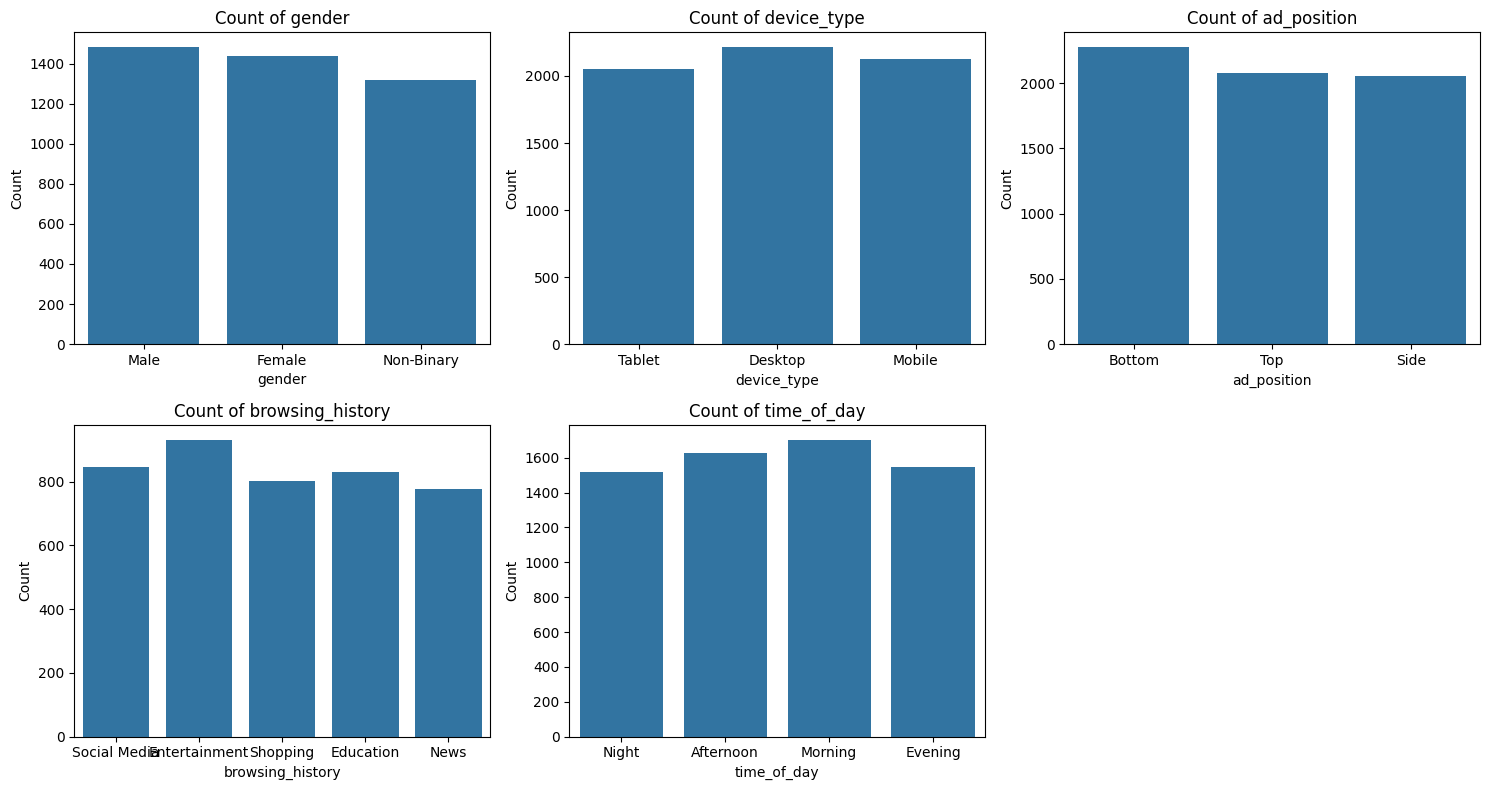

In [41]:
# Plotting barplots for all categorical variables
plt_categorical(adclicks)
plt_show('categorical_bar_plots')

From the plots, we see that most of the categorical features have a uniform distribution, except `browsing_history`, which has a slightly unimodal distribution. This information will be useful for dealing with missing data in these categories.

***

## Distribution of AGE

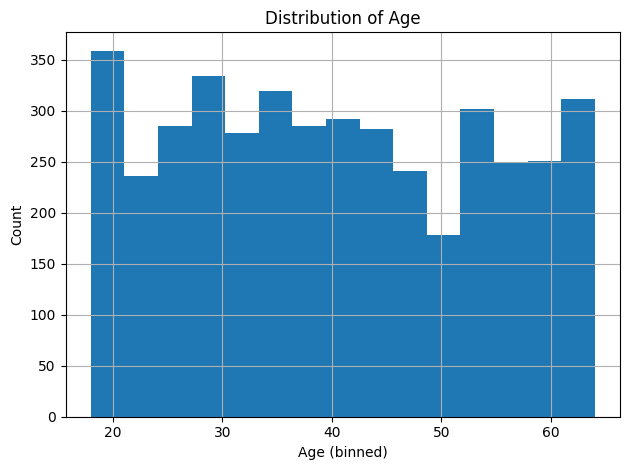

In [42]:
# Plotting the distribution of age in a histogram
adclicks['age'].hist(bins=15)
plt.xlabel('Age (binned)')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt_show('age_histogram')

By plotting the distribution of age in a histogram, we can see that it is a multimodal distribution, with a slight skew to the right. This indicates that most of the users are younger.

***

## Distribution of AGE across clicks/no clicks

We can also see the distribution of age amongst clicks and no clicks.

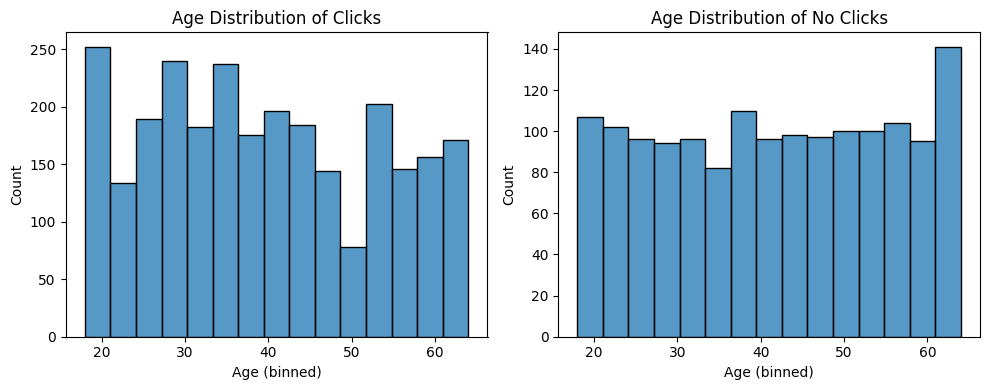

In [43]:
clicked = adclicks[adclicks['click']==1]
notclicked = adclicks[adclicks['click']==0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 4))

dfs = [clicked, notclicked]
names = ['Clicks', 'No Clicks']

# Configure display for each subplot
for ax, df, name in zip(axes.flatten(), dfs, names):
    # Create a bar plot for each categorical variable
    sns.histplot(x='age', data=df, ax=ax, bins=15)
    ax.set_title(f'Age Distribution of {name}')
    ax.set_xlabel('Age (binned)')
    ax.set_ylabel('Count')
    
plt_show('clicked_and_age_histogram')

Surprisingly, the distribution of age amongst clicks and no clicks are quite different. There are peaks in the click distribution at random age bins but there are also minimums between 21-24 and 48-51. The no click distribution is quite uniform throughout but there is a huge peak in 61-64.

***

## Boxplots with Age

We will be examining the relationships between the features, such as patterns of age within each gender and device type using boxplots.

In [44]:
# PLT_BOXPLOTS: a function to plot multiple boxplots for a numerical feature and multiple categorical features
def plt_boxplots(df, numerical_feature, categorical_features):
    
    # The number of categorical features
    num_categorical = len(categorical_features)

    # Creating a "square" plot
    sq_rows = math.floor(math.sqrt(num_categorical))
    sq_cols = num_categorical - sq_rows
    
    # Setting dimensions for figure
    fig, axes = plt.subplots(nrows=sq_rows, ncols=sq_cols, figsize=(5*sq_cols, 4*sq_rows))
    
    # Configure display for each subplot
    for ax, feature in zip(axes.flatten(), categorical_features):
        # Create a box plot for each categorical variable and the numerical feature
        sns.boxplot(x=feature, y=numerical_feature, data=df, ax=ax)
        ax.set_title(f'Boxplot of {numerical_feature} for each {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel(numerical_feature)

    # Make empty axes not visible
    for i in range(num_categorical, len(axes.flatten())):
        axes.flatten()[i].set_visible(False)
        
    # Adjust layout
    plt.tight_layout()

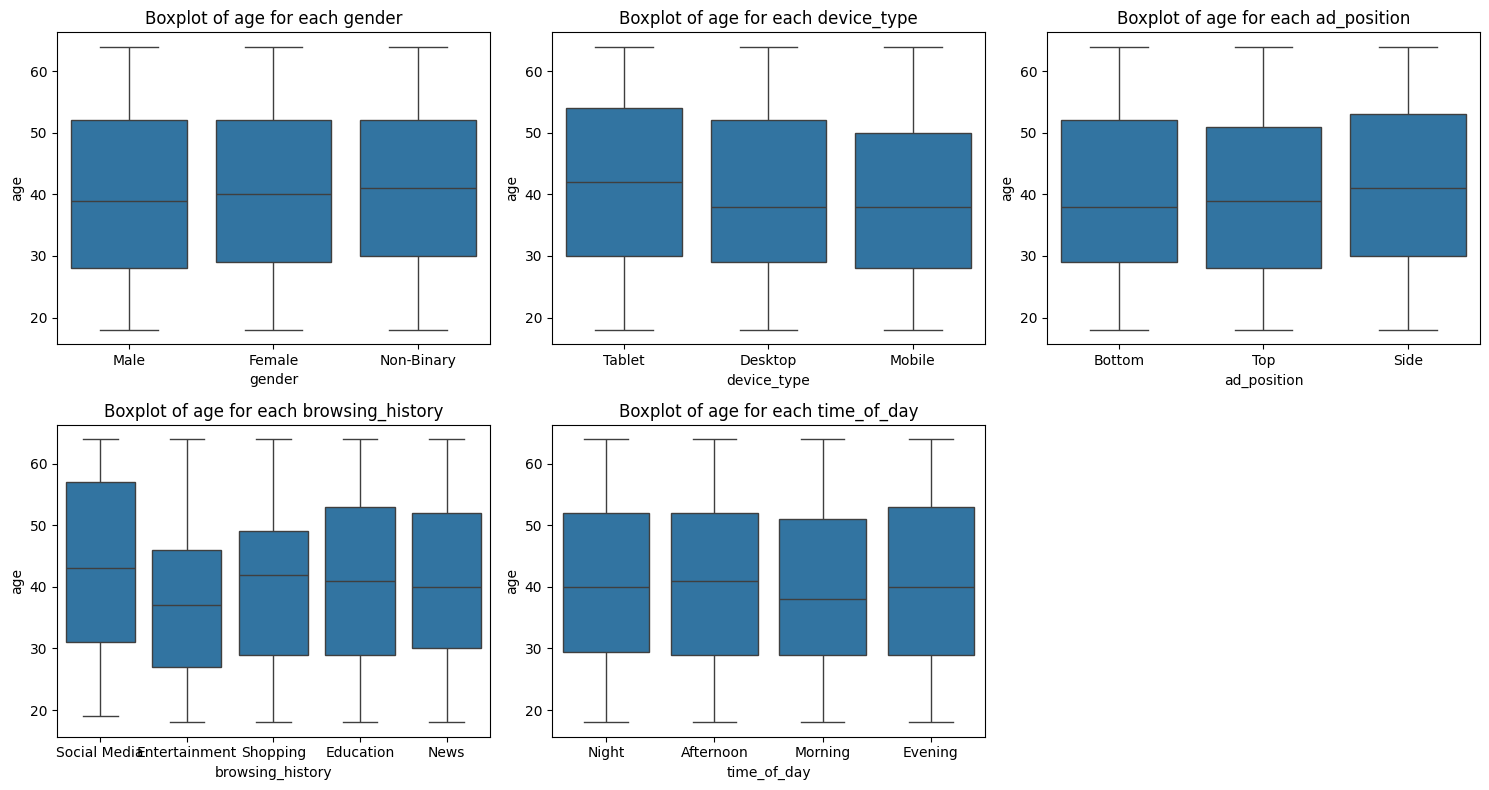

In [45]:
# Select the categorical features
categoricals = list(adclicks.select_dtypes(include=['category', 'object']).columns)

# Display boxplots
plt_boxplots(adclicks, 'age', categoricals)
plt_show('age_and_categorical_boxplots')

Interestigly, this dataset seems to be very well balanced in the distribution of age and each categorical feature. The boxplots across each level of the categorical features are consistent.

***

## Grouped Bar Plots: Interaction between 2 categorical features and clicks generated

We will now look at the interaction between 2 categorical features for each of the categorical features and the number of clicks it generated.

In [46]:
# PLT_GROUPED: plot grouped bar plots for each categorical feature relationship and the feature we want to measure
def plt_grouped(df, categorical_features, yfeature):
    
    # The number of categorical features
    num_categorical = len(categorical_features)

    # Creating a "square" plot
    sq_rows = sq_cols = num_categorical - 1
    
    # Setting dimensions for figure
    fig, axes = plt.subplots(nrows=sq_rows, ncols=sq_cols, figsize=(5*sq_cols, 4*sq_rows))
    
    # Creating combinations of categorical features
    c_features = categorical_features.copy()
    feature_ships = []
    
    for feature_a in categorical_features:
        a_index = c_features.index(feature_a)
        c_features.remove(feature_a)
        for feature_b in c_features:
            feature_ships.append((feature_a, feature_b))
        c_features.insert(a_index, feature_a)    

    # Configure display for each subplot
    for ax, feature_ship in zip(axes.flatten(), feature_ships):
        # Create a grouped bar plot for each relationship of categorical variable
        feature1 = feature_ship[0]
        feature2 = feature_ship[1]
        
        # Creating an aggregated table
        aggregated_table = df.groupby([feature1, feature2])[yfeature].sum()
        # Reset the index to use in seaborn
        aggregated_table_reset = aggregated_table.reset_index()
        
        sns.barplot(x=feature1, y=yfeature, hue=feature2, data=aggregated_table_reset, ax=ax)
        ax.set_title(f'Grouped barplot of {feature1} vs {feature2}')
        ax.set_xlabel(feature1)
        ax.set_ylabel(f'Number of {yfeature}')
        
    # Adjust layout
    plt.tight_layout()

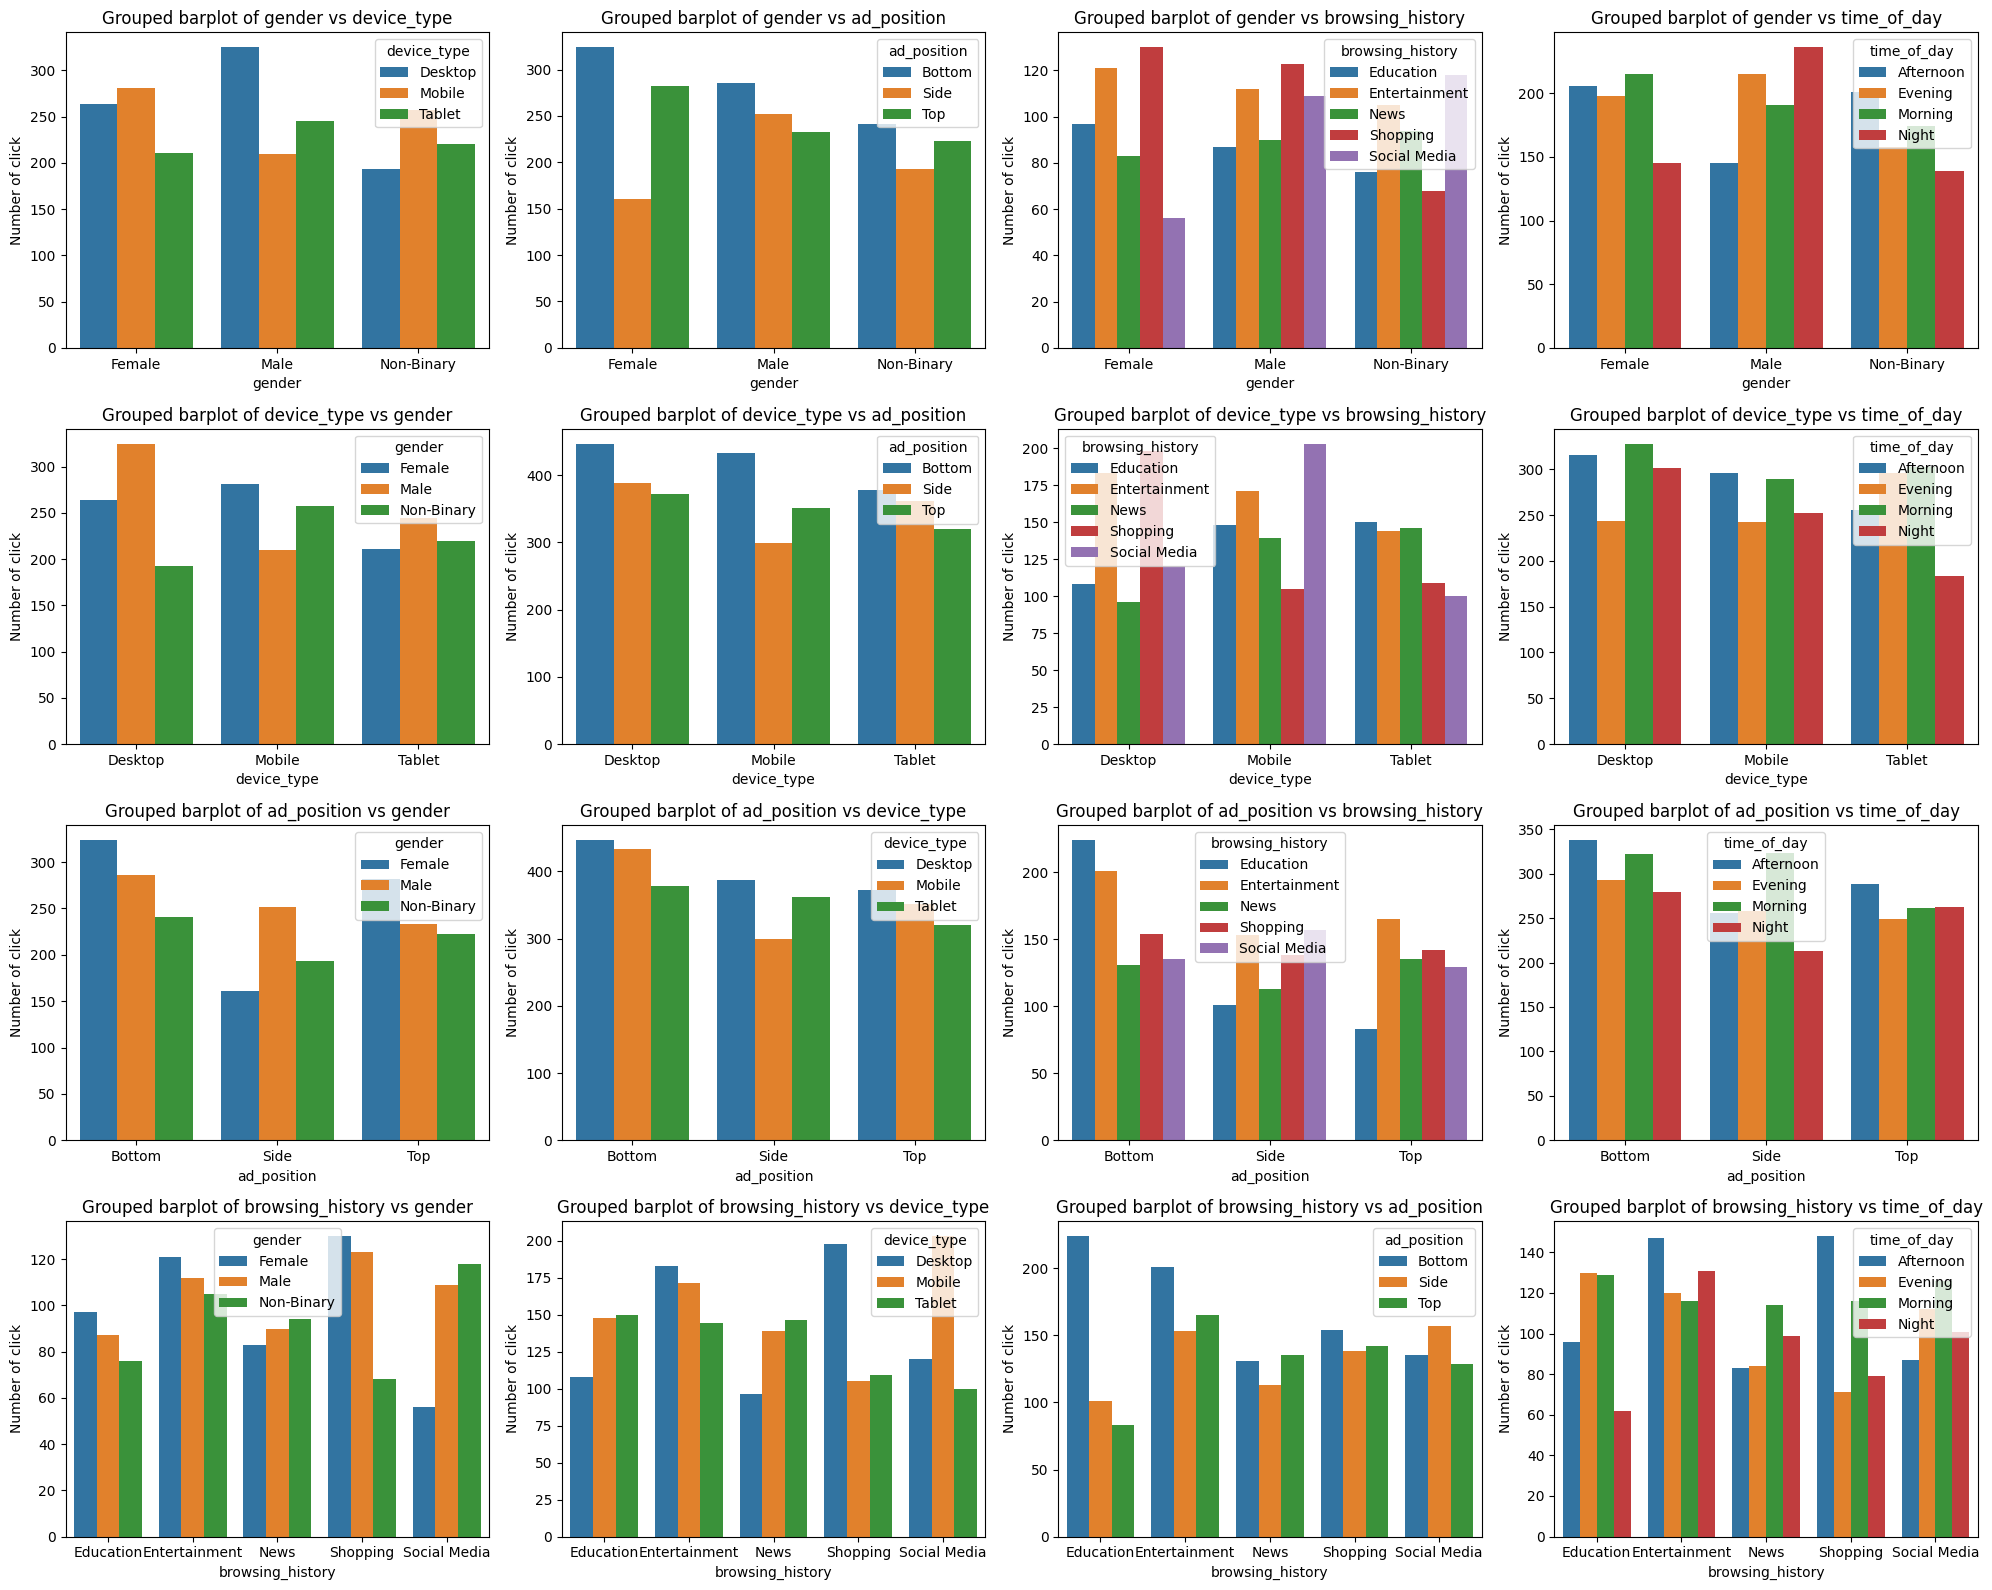

In [47]:
# Display grouped barplots and the sum of clicks
plt_grouped(adclicks, categoricals, 'click')
plt_show('grouped_categorical_barplots')

In the grouped bar plots, we can see the relationship between two categorical features and the number of clicks they generated. There are no hugely significant patterns but the following can be observed:

- Across the categorical features, the `Bottom` position for `ad_position` tends to generate the most clicks.
- Males tend to ads on the `Bottom` while females and non-binary people tend to click on ads located at the `Top`
- The `Afternoon` tends to generate the most activity and clicks.

***

In the next section, [B_preprocess.ipynb](/B_preprocess.ipynb), we will be performing any necessary data transformations before we start implementing models.